Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step p - accuracy: 0.5584 - 

Val F1: 0.8052
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.5594 - loss: 1.2599 - val_accuracy: 0.8051 - val_loss: 0.5245
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/stepep - accuracy: 0.9363 - l

Val F1: 0.8356
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9363 - loss: 0.2192 - val_accuracy: 0.8374 - val_loss: 0.4556
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/steptep - accuracy: 0.9882

Val F1: 0.8405
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.9882 - loss: 0.0644 - val_accuracy: 0.8424 - val_loss: 0.4435
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/steptep - accuracy: 0.996

Val F1: 0.8426
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.9962 - loss: 0.0295 - val_accuracy: 0.8444 - val_loss: 0.4401
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/steptep - accuracy: 0.999

Val F1: 0.8519
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9992 - loss: 0.0128

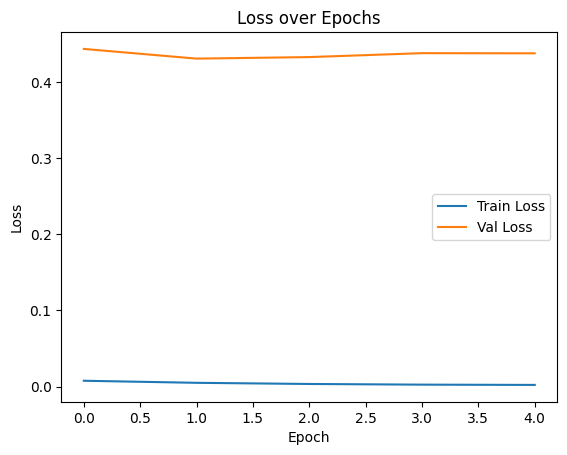

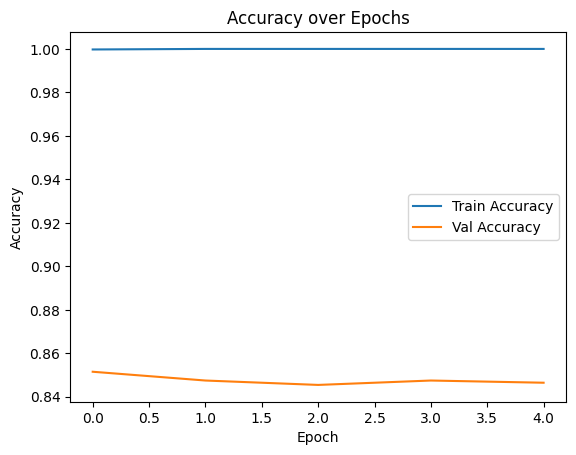

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# 데이터 준비
df = pd.read_csv('train_merged.csv')
df = df.rename(columns={'class': 'target'})

df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled['idx'] = range(len(df_shuffled))

# 레이블 인코딩
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

# 데이터 분할
X = df['conversation'].values.astype(str)
y = df['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# 텐서로 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.string)
X_val = tf.convert_to_tensor(X_val, dtype=tf.string)

# 텍스트 벡터화
VOCAB_SIZE = 20000
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=128
)
vectorize_layer.adapt(X_train)

# 트랜스포머 모델 구성
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128):
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    y = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    y = tf.keras.layers.Dense(inputs.shape[-1])(y)
    y = tf.keras.layers.Dropout(0.3)(y)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + y)

inputs = Input(shape=(1,), dtype=tf.string)
x = vectorize_layer(inputs)
x = tf.keras.layers.Embedding(VOCAB_SIZE, 128)(x)
x = transformer_encoder(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(len(le.classes_), activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# F1-score 콜백
class F1Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(X_val).argmax(axis=1)
        f1 = f1_score(y_val, y_pred, average='macro')
        print(f'\nVal F1: {f1:.4f}')

# 학습

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[F1Callback()]
)

# 손실(Loss) 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 정확도(Accuracy) 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

epochs = range(1, 6)
plt.figure(figsize=(15, 10))

# 1. 정확도(Accuracy) 그래프
plt.subplot(3, 1, 1)
plt.plot(epochs, train_acc, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Val Accuracy')
plt.title('Accuracy Trends')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. 손실(Loss) 그래프
plt.subplot(3, 1, 2)
plt.plot(epochs, train_loss, 'go-', label='Train Loss')
plt.plot(epochs, val_loss, 'mo-', label='Val Loss')
plt.title('Loss Trends')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. F1 스코어 그래프
plt.subplot(3, 1, 3)
plt.plot(epochs, val_f1, 'co-', label='Val F1 Score')
plt.title('F1 Score Trend')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


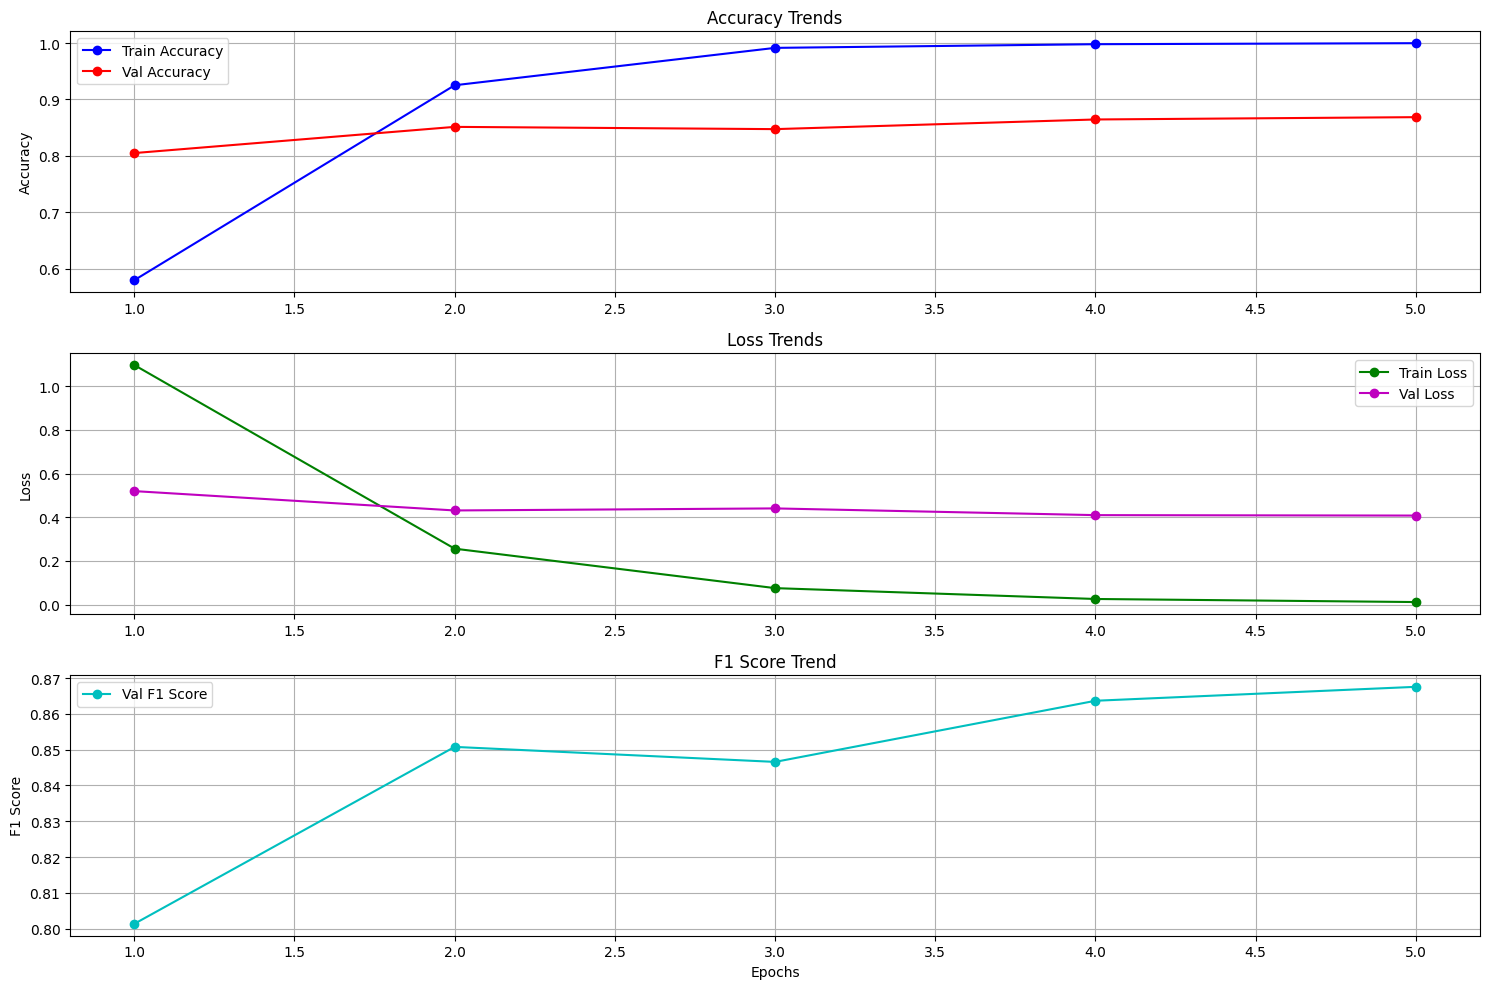

In [24]:
epochs = range(1, 6)
plt.figure(figsize=(15, 10))

# 1. 정확도(Accuracy) 그래프
plt.subplot(3, 1, 1)
plt.plot(epochs, train_acc, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Val Accuracy')
plt.title('Accuracy Trends')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. 손실(Loss) 그래프
plt.subplot(3, 1, 2)
plt.plot(epochs, train_loss, 'go-', label='Train Loss')
plt.plot(epochs, val_loss, 'mo-', label='Val Loss')
plt.title('Loss Trends')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. F1 스코어 그래프
plt.subplot(3, 1, 3)
plt.plot(epochs, val_f1, 'co-', label='Val F1 Score')
plt.title('F1 Score Trend')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model

# 데이터 준비
df = pd.read_csv('train_merged.csv')
df = df.rename(columns={'class': 'target'})


# 레이블 인코딩
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

# 데이터 분할
X = df['conversation'].values.astype(str)
y = df['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# 텐서로 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.string)
X_val = tf.convert_to_tensor(X_val, dtype=tf.string)

# 텍스트 벡터화
VOCAB_SIZE = 20000
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=128
)
vectorize_layer.adapt(X_train)

# 트랜스포머 모델 구성
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128):
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    y = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    y = tf.keras.layers.Dense(inputs.shape[-1])(y)
    y = tf.keras.layers.Dropout(0.3)(y)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + y)

inputs = Input(shape=(1,), dtype=tf.string)
x = vectorize_layer(inputs)
x = tf.keras.layers.Embedding(VOCAB_SIZE, 128)(x)
x = transformer_encoder(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(len(le.classes_), activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# F1-score 콜백
class F1Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(X_val).argmax(axis=1)
        f1 = f1_score(y_val, y_pred, average='macro')
        print(f'\nVal F1: {f1:.4f}')

# 학습
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32, callbacks=[F1Callback()])


Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step p - accuracy: 0.5799 - 

Val F1: 0.8013
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.5808 - loss: 1.0978 - val_accuracy: 0.8051 - val_loss: 0.5200
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/stepep - accuracy: 0.9252 - l

Val F1: 0.8508
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9252 - loss: 0.2562 - val_accuracy: 0.8515 - val_loss: 0.4313
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/steptep - accuracy: 0.9914 - l

Val F1: 0.8466
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.9914 - loss: 0.0754 - val_accuracy: 0.8475 - val_loss: 0.4407
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/stepep - accuracy: 0.9979 - 

Val F1: 0.8637
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.9979 - loss: 0.0257 - val_accuracy: 0.8646 - val_loss: 0.4099
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/steptep - accuracy: 0.9997 - l

Val F1: 0.8676
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.9997 - 

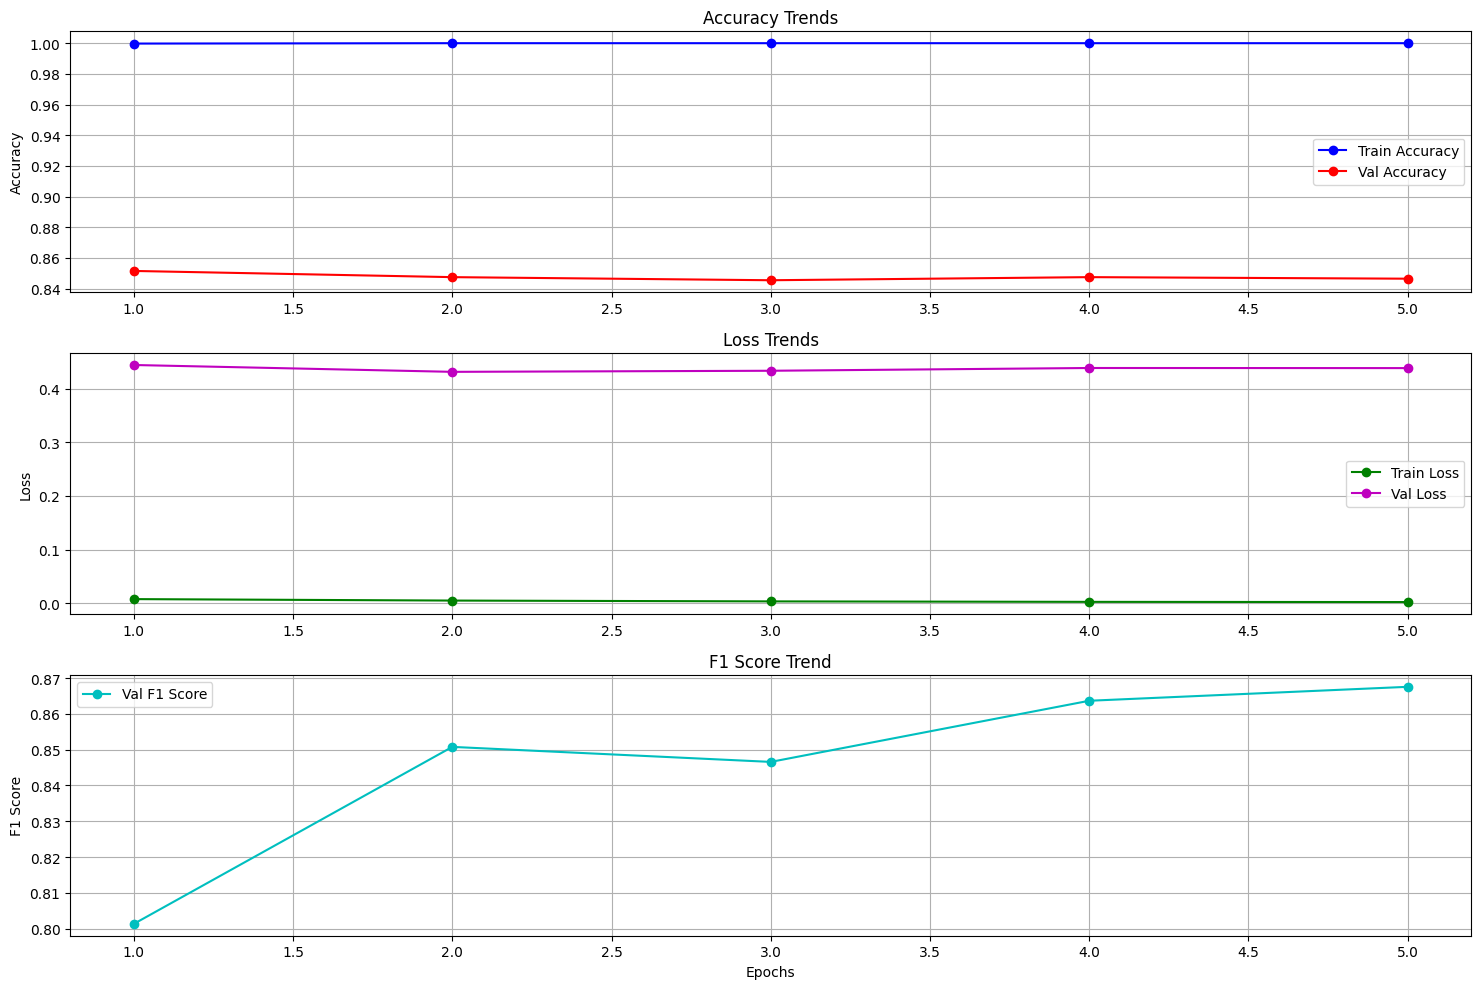

In [25]:
import matplotlib.pyplot as plt

# 에포크 수 자동 추출
epochs = range(1, len(history.history['loss']) + 1)

# 1. 정확도(Accuracy) 그래프
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(epochs, history.history.get('accuracy', history.history.get('acc')), 'bo-', label='Train Accuracy')
plt.plot(epochs, history.history.get('val_accuracy', history.history.get('val_acc')), 'ro-', label='Val Accuracy')
plt.title('Accuracy Trends')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. 손실(Loss) 그래프
plt.subplot(3, 1, 2)
plt.plot(epochs, history.history['loss'], 'go-', label='Train Loss')
plt.plot(epochs, history.history['val_loss'], 'mo-', label='Val Loss')
plt.title('Loss Trends')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. F1 스코어 그래프 (콜백에서 저장한 값 사용)
# F1 스코어는 history.history에 자동 저장되지 않으므로, 별도 리스트에 저장해야 함
# 예시: F1Callback에서 self.f1_scores에 저장했다고 가정
# 예시: f1_scores = [0.8013, 0.8508, 0.8466, 0.8637, 0.8676]
# 실제로는 F1Callback에서 값을 수집해야 함

f1_scores = [0.8013, 0.8508, 0.8466, 0.8637, 0.8676]  # 예시, 직접 저장한 값 사용
plt.subplot(3, 1, 3)
plt.plot(epochs, f1_scores, 'co-', label='Val F1 Score')
plt.title('F1 Score Trend')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[F1Callback()]
)



Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/stepep - accuracy: 1.0000 - loss:

Val F1: 0.8671
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 1.0000 - loss: 6.2551e-04 - val_accuracy: 0.8687 - val_loss: 0.4200
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/stepep - accuracy: 1.0000 - loss:

Val F1: 0.8746
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 1.0000 - loss: 5.6962e-04 - val_accuracy: 0.8758 - val_loss: 0.4173
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/stepep - accuracy: 1.0000 - loss:

Val F1: 0.8713
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 1.0000 - loss: 5.2726e-04 - val_accuracy: 0.8727 - val_loss: 0.4214
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/stepep - accuracy: 1.0000 - loss

Val F1: 0.8670
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 1.0000 - loss: 4.2553e-04 - val_accuracy: 0.8687 - val_loss: 0.4240
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/stepep - accuracy: 1.0000 - los

Val F1: 0.8724
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


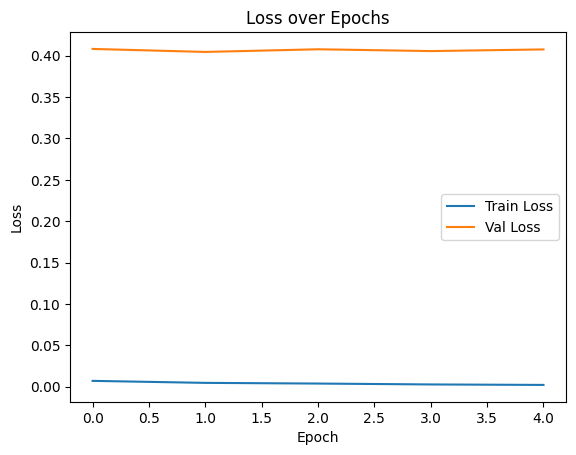

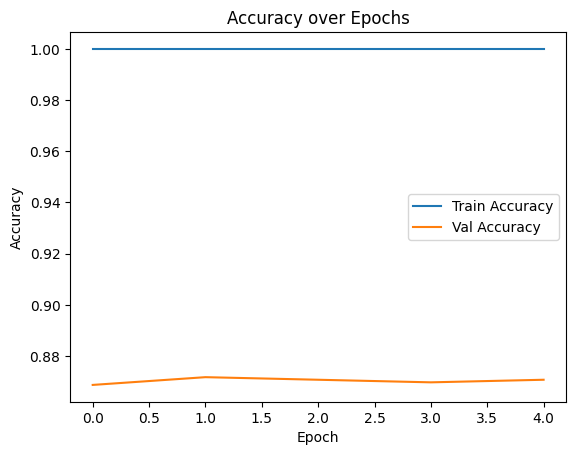

In [13]:
print(history.history.keys())
# 예시 출력: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
import matplotlib.pyplot as plt

# 손실(Loss) 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 정확도(Accuracy) 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[F1Callback(), tensorboard_callback]
)


Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/stepep - accuracy: 1.0000 - 

Val F1: 0.8714
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8727 - val_loss: 0.4084
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/stepep - accuracy: 1.0000 -

Val F1: 0.8684
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8697 - val_loss: 0.4078
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/steptep - accuracy: 1.0000 - l

Val F1: 0.8747
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8758 - val_loss: 0.4073
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/stepep - accuracy: 1.0000 - l

Val F1: 0.8726
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8737 - val_loss: 0.4096
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/stepep - accuracy: 1.0000 - lo

Val F1: 0.8673
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 1.0000 - l

데이터 합치기기

In [17]:
import pandas as pd
import glob

# 1. train 폴더 안의 모든 .tsv 파일 경로 가져오기
file_list = glob.glob('train/*.tsv')  # 또는 './train/*.tsv'

# 2. 각 파일을 DataFrame으로 읽어 리스트에 저장
dfs = [pd.read_csv(f, sep='\t') for f in file_list]

# 3. 데이터프레임 합치기
merged = pd.concat(dfs, ignore_index=True)

# 4. CSV로 저장
merged.to_csv('train_merged.csv', index=False, encoding='utf-8')


ValueError: No objects to concatenate